# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
#for Windows
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

df = spark.sql('''select 'spark' as hello ''')
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



In [2]:
# import libraries
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, desc, asc, sum as Fsum, max as Fmax
from pyspark.sql.types import IntegerType, StringType

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# create a Spark session
# docs here: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html
# configure = SparkConf().setAppName("Sparkify").setMaster("local")
    #     for SparkSession # .config(conf=configure) \
spark = SparkSession \
    .builder \
    .getOrCreate()
    
    

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [4]:
df = spark.read.json('mini_sparkify_event_data.json')
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#num rows
df.count()

286500

In [7]:
df = df.dropna(thresh=15)
df.count()

278154

In [8]:
278154/286500

0.970869109947644

In [9]:
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [10]:
df.groupBy(df.page).count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [11]:
print(f"Number who confirmed cancellation: {df.where(df.page=='Cancellation Confirmation') \
    .count()}")
df.where(df.page=='Cancellation Confirmation') \
    .groupBy('gender')\
    .count() \
    .show()

Number who confirmed cancellation: 52
+------+-----+
|gender|count|
+------+-----+
|     F|   20|
|     M|   32|
+------+-----+



In [12]:
print(df.columns)

['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']


## Defining Customer Churn
For the sake of this exercise, customers who "churn" will be those who reach the "Cancellation Confirmation" page.

In [13]:
churns = list(df.where(df.page=='Cancellation Confirmation').select('userId').toPandas()['userId'])

In [14]:
churns = set([int(x) for x in churns])

In [15]:
print(churns)

{129, 3, 12, 143, 17, 18, 28, 29, 32, 100001, 100003, 100005, 100006, 100007, 100009, 100011, 100012, 100013, 100014, 100015, 100017, 51, 100019, 53, 54, 100023, 100024, 100025, 58, 100022, 100021, 200001, 70, 73, 200011, 200015, 200016, 200017, 200018, 200020, 200021, 87, 200024, 300001, 101, 103, 300007, 105, 106, 121, 122, 125}


In [16]:
flag_churn = udf(lambda x: 1 if int(x) in churns else 0, IntegerType())

In [17]:
#downgrade = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [18]:
df = df.withColumn('churns', flag_churn(df.userId))

In [19]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churns=0)

## Examining page visits between users who 'churn' and users who don't

In [26]:
num_churn = df.where(df.churns==1).select('userId').distinct().count()

In [27]:
num_stay = df.where(df.churns==0).select('userId').distinct().count()

In [30]:
total = df.select('userId').distinct().count()

In [62]:
#amounts in each group
num_churn, num_stay, total

(52, 173, 225)

In [63]:
#raw data for users who churn and don't
churns_comp_df = df.crosstab('churns','page').toPandas()
churns_comp_df

,churns_page,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,1,56,636,1038,52,52,337,32,239,1672,553,36394,967,58,270,9,32,496,1859,112
1,0,439,3641,5488,0,0,1718,220,1215,8410,2673,191714,2966,252,1244,54,127,2050,10692,387


In [64]:
#normalize data to per user numbers
churns_comp_df['churns_page'] = pd.to_numeric(churns_comp_df['churns_page'])

In [65]:
churns_comp_df.values[0] = churns_comp_df.values[0]/num_churn

In [66]:
churns_comp_df.values[1] = churns_comp_df.values[1]/num_stay

In [67]:
#reinsert binary for churning and not (floor division removes the in the churns_page column)
churns_comp_df['churns_page'] = [1,0]

In [69]:
churns_comp_df

,churns_page,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,1,1,12,19,1,1,6,0,4,32,10,699,18,1,5,0,0,9,35,2
1,0,2,21,31,0,0,9,1,7,48,15,1108,17,1,7,0,0,11,61,2


## Observations
"Cancellation Confirmation" being 1 for the churn row and 0 for the non-churn row affirms that the normalization was done correctly. Quick observations show that those who didn't churn were generally more 'hands on.' They visited the "NextSong" page over 50% more than those who did churn. They visited settings slightly more, the home page, and added almost twice as many friends. Those who didn't churn also hit the "thumbs up" nearly twice as much, likely allowing Sparkify to better match songs for the user.

In [ ]:
#DO SOMETHING LIKE THIS
# from https://stackoverflow.com/questions/28576540/how-can-i-normalize-the-data-in-a-range-of-columns-in-my-pandas-dataframe
# cols_to_norm = ['Age','Height']
# survey_data[cols_to_norm] = survey_data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [75]:
#Normalize columns
cols_to_norm = ['About','Add Friend', 'Add to Playlist', 'Downgrade', 'Help', 'Home', 'Logout', 
                'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Thumbs Down', 'Thumbs Up', 'Upgrade']
churns_comp_df[cols_to_norm] = churns_comp_df[cols_to_norm].apply(lambda x: x / x.sum())


In [76]:
churns_comp_df

,churns_page,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,1,0.333333,0.363636,0.38,1,1,0.4,0,0.363636,0.4,0.4,0.386829,0.514286,0.5,0.416667,0,0,0.45,0.364583,0.5
1,0,0.666667,0.636364,0.62,0,0,0.6,1,0.636364,0.6,0.6,0.613171,0.485714,0.5,0.583333,0,0,0.55,0.635417,0.5


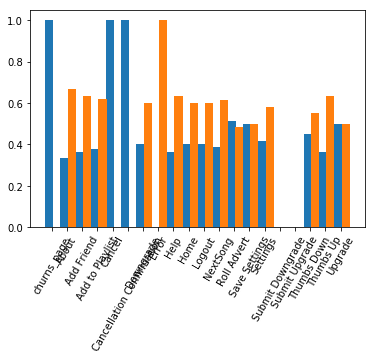

In [114]:
plt.bar(x=[x*1.5-.75 for x in range(0,len(churns_comp_df.columns))],height=churns_comp_df.iloc[0])
plt.bar(x=[x*1.5 for x in range(0,len(churns_comp_df.columns))],height=churns_comp_df.iloc[1])
plt.xticks([x*1.5-.5 for x in range(0,len(churns_comp_df.columns))],churns_comp_df.columns,rotation=60);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.